### THis is used to get PCA for the ELMo embeddings to see if there is any main component lying in the difference between he-related ELMo with she-related ELMo

In [1]:
%load_ext autoreload
%autoreload 2
import utils
from scipy import spatial
import pandas as pd
import numpy as np
from tqdm import tqdm
import h5py

In [2]:
import json

In [3]:
train = 'data/anonymized/train.english.jsonlines'

In [4]:
he_genders = utils.get_all_genders(train, utils.male_words)
she_genders = utils.get_all_genders(train, utils.female_words)

In [5]:
len([x for x in she_genders if len(she_genders[x]) > 0])

893

In [6]:
he_genders['bc/cctv/00/cctv_0001_3']

defaultdict(list, {2: [4]})

In [7]:
train_file = 'elmo_caches/elmo_caches/elmo_cache_train.hdf5'
train = h5py.File(train_file, 'r')
train_swap_file = 'elmo_caches/elmo_caches/elmo_cache_train_swap.hdf5'
train_swap = h5py.File(train_swap_file, 'r')

In [21]:
list(train.keys())[-1]

'wb:eng:00:eng_0017_5'

In [22]:
train['wb:eng:00:eng_0017_5']

<HDF5 group "/wb:eng:00:eng_0017_5" (39 members)>

In [8]:
he_elmo_ori = utils.get_gender_elmo(train, he_genders)
she_elmo_ori = utils.get_gender_elmo(train, she_genders)
she_elmo_swap = utils.get_gender_elmo(train_swap, he_genders)
he_elmo_swap = utils.get_gender_elmo(train_swap, she_genders)

100%|██████████| 2802/2802 [00:26<00:00, 105.18it/s]


In [11]:
def get_examples(file = 'train', path = 'conll-2012'):
    with open('data/%s/%s.english.jsonlines'%(path, file)) as f:
        examples = [json.loads(jsonline) for jsonline in f.readlines()]
    return examples

In [12]:
from collections import defaultdict

In [13]:
def filter_sentences(examples, all_prof, male_words, female_words):
    he = []
    she = []
    for doc in examples:
        for sent_id in range(len(doc['sentences'])):
            sentence = [x.lower() for x in doc['sentences'][sent_id]]
            m_flag = 0
            f_flag = 0
#             print(doc['sentences'][sent_id])
#             if 'he' in sentence or 'him' in sentence or 'his' in sentence or 'she' in sentence or 'her' in sentence:

            for job in all_prof:
                if job.lower() in sentence:
                    for male in male_words:
                        if male.lower() in sentence: #there is a male definition words in the sentence
#                             if ('he' in sentence or 'him' in sentence or 'his' in sentence) and 'she' not in sentence and 'her' not in sentence:
#                             he.append([doc['doc_key'], sent_id, sentence.index(job.lower()), ' '.join(doc['sentences'][sent_id])])
                            
                            m_flag = 1
                            break
                    for female in female_words:
                        if female.lower() in sentence:
#                             elif ('she' in sentence or 'her' in sentence) and 'he' not in sentence and 'him' not in sentence and 'his' not in sentence:
#                             she.append([doc['doc_key'], sent_id, sentence.index(job.lower()), ' '.join(doc['sentences'][sent_id])])
                            
                            f_flag = 1
                            break
                    if m_flag == 1 and f_flag == 0:
                        he.append([doc['doc_key'], sent_id, sentence.index(job.lower()), ' '.join(doc['sentences'][sent_id])])
                    if m_flag == 0 and f_flag == 1:
                        she.append([doc['doc_key'], sent_id, sentence.index(job.lower()), ' '.join(doc['sentences'][sent_id])])
    print("%d instances with he; %d with she"%(len(he), len(she)))
    return he,she

In [14]:
he_train, she_train = filter_sentences(get_examples('train'), utils.male_occs+utils.female_occs,\
                                                     utils.male_words, utils.female_words)
he_dev, she_dev = filter_sentences(get_examples('dev'), utils.male_occs+utils.female_occs,\
                                                     utils.male_words, utils.female_words)

400 instances with he; 83 with she
50 instances with he; 6 with she


In [15]:
def get_vec(traink, f):
    train_vec = []
    for key in traink:
        ekey = key[0].replace('/', ':')
#         fl1 = np.mean(f[ekey][str(key[1])][key[2]], axis = 1)
        fl1 = np.array(f[ekey][str(key[1])][key[2]]).flatten()
        train_vec.append(fl1)
    return train_vec

In [16]:
he_elmo_ori = get_vec(he_train, train)
she_elmo_ori = get_vec(she_train, train)

In [17]:
she_elmo_swap = get_vec(he_train, train_swap)
he_elmo_swap = get_vec(she_train, train_swap)

In [18]:
dev_file = 'elmo_caches/elmo_caches/elmo_cache_dev.hdf5'
dev = h5py.File(dev_file, 'r')
dev_swap_file = 'elmo_caches/elmo_caches/elmo_cache_dev_swap.hdf5'
dev_swap = h5py.File(dev_swap_file, 'r')
he_elmo_ori_dev = get_vec(he_dev, dev)
she_elmo_ori_dev = get_vec(she_dev, dev)
she_elmo_swap_dev = get_vec(he_dev, dev_swap)
he_elmo_swap_dev = get_vec(she_dev, dev_swap)

In [19]:
print(len(he_elmo_swap), len(she_elmo_swap))

83 400


In [20]:
import numpy as np

In [21]:
from sklearn.decomposition import PCA

In [22]:
he_elmo = np.array(he_elmo_ori) #he_elmo_ori + 
she_elmo = np.array(she_elmo_swap) #she_elmo_swap + 

In [23]:
he_elmo.shape

(400, 3072)

In [24]:
diff_elmo = he_elmo.reshape(-1, 3072) - she_elmo.reshape(-1, 3072)

In [25]:
diff_elmo.shape

(400, 3072)

In [26]:
pca = PCA(n_components=10)
pca.fit(diff_elmo)

PCA(copy=True, iterated_power='auto', n_components=10, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [27]:
print(pca.components_)

[[ 8.5702641e-03 -1.1756741e-02 -2.3149204e-02 ...  1.7315379e-03
  -1.3946895e-02 -2.0262994e-02]
 [-3.9222687e-02  9.7004529e-03 -1.1888623e-02 ... -7.9245381e-03
   2.2751901e-03  8.4084272e-03]
 [ 5.3460943e-03  1.7833155e-02  7.0083119e-02 ...  1.0801100e-03
  -6.4731603e-03 -8.7928800e-03]
 ...
 [-3.1685445e-04  8.6785406e-03  4.0965392e-03 ... -6.3984604e-05
   2.4063686e-02 -1.1676338e-02]
 [ 1.4010265e-03 -2.8662039e-03  1.4980823e-02 ...  2.8264936e-04
  -1.1514841e-02  4.4461256e-03]
 [ 2.2185899e-03  3.1074332e-03  3.6849700e-02 ...  4.4799942e-04
   1.7107269e-02 -2.1650327e-02]]


In [28]:
print(pca.explained_variance_)

[8.24094    6.8122854  2.6736727  1.0588751  0.588591   0.44575515
 0.41949478 0.40299028 0.33438137 0.2887907 ]


In [29]:
pca.explained_variance_ratio_

array([0.2665421 , 0.22033419, 0.08647633, 0.03424789, 0.01903718,
       0.01441735, 0.01356799, 0.01303418, 0.01081511, 0.00934055],
      dtype=float32)

In [30]:
import matplotlib.pyplot as plt

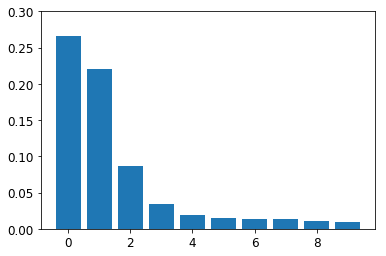

In [31]:
plt.bar(range(len(pca.explained_variance_)), pca.explained_variance_ratio_)
plt.xticks(range(0,10,2), fontsize=12)
plt.yticks(np.arange(0,0.35, 0.05), fontsize=12)
plt.savefig('PCA.pdf')

In [32]:
# components = pca.transform(diff_elmo)
# fig = plt.figure(figsize = (8,8))
# ax = fig.add_subplot(1,1,1) 
# ax.set_xlabel('Principal Component 1', fontsize = 15)
# ax.set_ylabel('Principal Component 2', fontsize = 15)
# ax.set_title('2 component PCA', fontsize = 20)
# colors = ['g', 'b', 'r']
# ax.scatter(components[:,0],
#             components[:, 1]
#                , c = 'b'
#                , s = 50)
# ax.grid()

In [33]:
eigenvecs = pca.components_
eigenvalues = pca.explained_variance_

In [34]:
eigenvecs.shape

(10, 3072)

In [35]:
dev_he_elmo = np.array(he_elmo_swap).reshape(-1, 3072)
dev_she_elmo = np.array(she_elmo_ori).reshape(-1, 3072)

In [36]:
# ncom = 1
# diff_vec = np.zeros(eigenvecs.shape[1])
# for ind in range(ncom):
#     diff_vec += eigenvalues[ind] * eigenvecs[ind] 
    
# dev_he_elmo_af = dev_he_elmo - 1/2 * diff_vec
# dev_she_elmo_af = dev_she_elmo + 1/2*diff_vec
# simsx = []
# for ind in range(dev_he_elmo_af.shape[0]):
#     sim = 1 - spatial.distance.cosine(dev_he_elmo_af[ind], dev_she_elmo_af[ind])
#     simsx.append(sim) 
# sim = pd.DataFrame(simsx)
# sim.describe()

In [37]:
dev_gender = np.average(he_elmo_swap, axis = 0)

In [56]:
x = np.average(np.array(he_elmo_swap).reshape(83,-1, 1024), axis = 1) 
y = np.average(np.array(she_elmo_ori).reshape(83,-1, 1024), axis = 1)

In [57]:
dev_gender = x - y

In [62]:
[1 - spatial.distance.cosine(dev_gender[0], dev_gender[idx]) for idx in range(len(dev_gender))]

[1.0,
 0.7298371195793152,
 0.03335016593337059,
 0.8362194895744324,
 0.4601539969444275,
 -0.004503151867538691,
 0.48090946674346924,
 -0.003734349738806486,
 0.6213304996490479,
 -0.01649998314678669,
 0.6775102615356445,
 0.6631143689155579,
 0.3907794952392578,
 0.042437344789505005,
 0.8303622603416443,
 0.6716808676719666,
 nan,
 0.9041508436203003,
 0.4975203275680542,
 0.4996858835220337,
 0.6563803553581238,
 0.29692593216896057,
 nan,
 0.3100317716598511,
 0.6496907472610474,
 0.4724295437335968,
 0.0052075255662202835,
 -0.017462292686104774,
 0.631690263748169,
 -0.011652122251689434,
 0.46980854868888855,
 -0.008242924697697163,
 0.5528157353401184,
 0.5429109930992126,
 -0.014651504345238209,
 0.7494402527809143,
 0.7402806878089905,
 0.6906407475471497,
 0.780219316482544,
 -0.018477369099855423,
 -0.008391724899411201,
 0.48146185278892517,
 0.39187151193618774,
 -0.011136399582028389,
 0.45354095101356506,
 -0.003132750978693366,
 -0.0061707524582743645,
 0.335314869

### 2. project out the 1st and 2nd dimension

In [237]:
pc1 = pca.components_[0]
pc2 = pca.components_[1]
pc3 = pca.components_[2]

In [238]:
pc1.shape

(3072,)

In [223]:
def get_sims(elmo1, elmo2):
    simsx = []
    for ind in range(elmo1.shape[0]):
        sim = 1 - spatial.distance.cosine(elmo1[ind], elmo2[ind])
        simsx.append(sim) 
    sim = pd.DataFrame(simsx)
    return sim

In [224]:
dev_he_po1 = dev_he_elmo - np.multiply((dev_he_elmo.dot(pc1) / (pc1.dot(pc1))).reshape(-1,1), 
                                       pc1.reshape(1, -1))
dev_she_po1 = dev_she_elmo - np.multiply((dev_she_elmo.dot(pc1) / (pc1.dot(pc1))).reshape(-1,1), 
                                       pc1.reshape(1, -1))

In [225]:
pc1

array([ 0.00857029, -0.01175674, -0.02314921, ...,  0.00173153,
       -0.01394689, -0.02026298], dtype=float32)

In [226]:
sim = get_sims(dev_he_elmo, dev_she_elmo)
sim.describe()

,0
count,83.000000
mean,0.990325
std,0.010204
min,0.946624
25%,0.985752
50%,0.992591
75%,0.997549
max,1.000000


In [227]:
sim_po1 = get_sims(dev_he_po1, dev_she_po1)
sim_po1.describe()

,0
count,83.000000
mean,0.993707
std,0.005594
min,0.978273
25%,0.991319
50%,0.995547
75%,0.997821
max,1.000000


In [228]:
pc2

array([-0.03922274,  0.00970044, -0.01188857, ..., -0.00792454,
        0.00227519,  0.00840843], dtype=float32)

In [229]:
dev_he_po2 = dev_he_po1 - np.multiply((dev_he_po1.dot(pc2) / (pc2.dot(pc2))).reshape(-1,1), 
                                       pc2.reshape(1, -1))
dev_she_po2 = dev_she_po1 - np.multiply((dev_she_po1.dot(pc2) / (pc2.dot(pc2))).reshape(-1,1), 
                                       pc2.reshape(1, -1))

In [230]:
sim_po2 = get_sims(dev_he_po2, dev_she_po2)
sim_po2.describe()

,0
count,83.000000
mean,0.993936
std,0.005385
min,0.978192
25%,0.991245
50%,0.995952
75%,0.997855
max,1.000000


In [231]:
dev_he_po3 = dev_he_po2 - np.multiply((dev_he_po2.dot(pc3) / (pc3.dot(pc3))).reshape(-1,1), 
                                       pc3.reshape(1, -1))
dev_she_po3 = dev_she_po2 - np.multiply((dev_she_po2.dot(pc3) / (pc3.dot(pc3))).reshape(-1,1), 
                                       pc3.reshape(1, -1))
sim_po3 = get_sims(dev_he_po3, dev_she_po3)
sim_po3.describe()

,0
count,83.000000
mean,0.996320
std,0.003410
min,0.985143
25%,0.994755
50%,0.997432
75%,0.998647
max,1.000000


In [232]:
np.linalg.norm(dev_he_po3 - dev_she_po3, 2)

10.387078

In [233]:
print("L2 dis without projecting:", np.linalg.norm(dev_he_elmo - dev_she_elmo, 2))
print("L2 dis after projecting out the 1st PC:", np.linalg.norm(dev_he_po1 - dev_she_po1, 2))
print("L2 dis after projecting out the 1st & 2nd PC:", np.linalg.norm(dev_he_po2 - dev_she_po2, 2))
print("L2 dis after projecting out the 1st & 2nd & 3rd PC:", np.linalg.norm(dev_he_po3 - dev_she_po3, 2))

L2 dis without projecting: 34.0194
L2 dis after projecting out the 1st PC: 26.0915
L2 dis after projecting out the 1st & 2nd PC: 25.3866
L2 dis after projecting out the 1st & 2nd & 3rd PC: 10.3871


### 3. Visualization some words

In [239]:
import json

In [240]:
dev = 'data/anonymized/dev.english.jsonlines'

In [241]:
he_dev_gender = utils.get_all_genders(dev, utils.male_words)
he_dev_words = utils.get_gender_words(dev, utils.male_words)

In [242]:
list(he_dev_words.keys())[:3]

['bc/cctv/00/cctv_0000_0', 'bc/cctv/00/cctv_0000_1', 'bc/cctv/00/cctv_0000_2']

In [243]:
he_dev_words['bc/cctv/00/cctv_0000_0']

defaultdict(list, {})

In [244]:
he_dev_gender['bc/cctv/00/cctv_0000_0']

defaultdict(list, {})

In [245]:
dev_T1_file = 'elmo_caches/elmo_cache_dev_T1_pro.hdf5'
dev_T1 = h5py.File(dev_T1_file, 'r')
dev_T1_file_anti = 'elmo_caches/elmo_cache_dev_T1_anti.hdf5'
dev_T1_anti = h5py.File(dev_T1_file_anti, 'r')

In [56]:
with open('/home/jyzhao/Github/data/jobs') as f:
    all_prof = [x.strip().lower() for x in f.readlines()]

In [57]:
male = '/home/jyzhao/Github/data/corefBias/WinoBias/wino/data/male_occupations.txt'
female = '/home/jyzhao/Github/data/corefBias/WinoBias/wino/data/female_occupations.txt'
male_occs = [x.strip() for x in open(male).readlines()]
female_occs = [x.strip() for x in open(female).readlines()]
f_m =  female_occs + male_occs 
m_f = male_occs + female_occs

In [327]:
all_prof = m_f
_, she_anti = utils.filter_sentences(utils.get_examples(
    'dev_type1_anti_stereotype', 'corefbias'), all_prof)
he_pro, _ = utils.filter_sentences(utils.get_examples(
    'dev_type1_pro_stereotype', 'corefbias'), all_prof)
all_prof = f_m
he_anti, _ = utils.filter_sentences(utils.get_examples(
    'dev_type1_anti_stereotype', 'corefbias'), all_prof)
_, she_pro = utils.filter_sentences(utils.get_examples(
    'dev_type1_pro_stereotype', 'corefbias'), all_prof)

175 instances with he; 177 with she
177 instances with he; 175 with she
175 instances with he; 177 with she
177 instances with he; 175 with she


In [329]:
he_anti['nw/dev_type1/stereotype//101_0']

defaultdict(list,
            {0: [(4,
               'The mechanic greets the receptionist because he was standing in front of the door .')]})

In [322]:
she_anti['nw/dev_type1/stereotype//104_0']

defaultdict(list,
            {0: [(1,
               'The farmer gave the teacher a bag of eggs because she was grateful .')]})

In [330]:
def get_word_elmo(elmo_file, filtered):
    res = []
    elmos = []
    for key in filtered.keys(): 
        elmo_key = key.replace('/', ':')
        sen_id = list(filtered[key].keys())[0]
        assert sen_id == 0
        for wid, sent in filtered[key][sen_id]:
            elmo = elmo_file[elmo_key][str(sen_id)][wid]
            word = sent.strip().split()[wid]
            res.append((word, wid, sent))
            elmos.append(elmo)
    return res, elmos

In [319]:
list(he_anti.keys())[:3]

['nw/dev_type1/stereotype//101_0',
 'nw/dev_type1/stereotype//102_0',
 'nw/dev_type1/stereotype//105_0']

In [331]:
he_res_anti, he_elmos_anti = get_word_elmo(dev_T1_anti, he_anti)
he_res_pro, he_elmos_pro = get_word_elmo(dev_T1, he_pro)
she_res_pro, she_elmos_pro = get_word_elmo(dev_T1, she_pro)
she_res_anti, she_elmos_anti = get_word_elmo(dev_T1_anti, she_anti)
he_res, he_elmos  = get_word_elmo(dev_T1, he_pro)
she_res, she_elmos = get_word_elmo(dev_T1_anti, she_anti)

In [335]:
she_res_pro[:3]

[('receptionist',
  4,
  'The mechanic greets the receptionist because she was standing in front of the door .'),
 ('assistant',
  6,
  'The cook is always teaching the assistant new techniques so she will one day be equal in skill .'),
 ('teacher',
  4,
  'The farmer gave the teacher a bag of eggs because she helped many kids .')]

In [274]:
gendercoref_he = h5py.File('./elmo_caches/elmo_cache_gendercoref_he.hdf5')
gendercoref_she = h5py.File('./elmo_caches/elmo_cache_gendercoref_she.hdf5')

In [275]:
len(gendercoref_she.keys())

900

In [276]:
gendercoref_she['nw:30_0']['0']

<HDF5 dataset "0": shape (16, 1024, 3), type "<f4">

In [277]:
#gendercoref-she: the occ is the 1st word and pronoun is 10th
#gendercoref-he: the occ is the 4th and pronoun is 10th
gendercoref_inds = [0, 31, 62, 124, 155, 217]#, 90, 120, 150, 180, 210]
gendercoref_male_words = ['actor',  'prince',  'gentleman','chairman', 'waiter', 'monk']
gendercoref_female_words = ['actress', 'princess', 'lady', 'chairwoman', 'waitress', 'nun']
gendercoref_male_elmos = []
gendercoref_female_elmos = []
for ind in gendercoref_inds:
    key = 'nw:' + str(ind) + '_0'
    he_occ_male_context = gendercoref_he[key]['0'][4] #actor-he
#     she_occ_male_context = gendercoref_he[key]['0'][1] #actress-he
#     he_occ_female_context = gendercoref_she[key]['0'][4] #actor-she
    she_occ_female_context = gendercoref_she[key]['0'][1] #actress-she
    gendercoref_male_elmos.append(he_occ_male_context)
#     gendercoref_female_elmos.append(he_occ_female_context)
#     gendercoref_male_elmos.append(she_occ_male_context)
    gendercoref_female_elmos.append(she_occ_female_context) 

In [278]:
len(gendercoref_male_elmos)

6

In [279]:
rands = range(len(gendercoref_inds))
proj_gendercoref_he = []
proj_gendercoref_she = []
pcs = pca.components_
for ind in range(len(gendercoref_female_elmos)):
        tmp = []
        for i in range(3):
            he_emb = gendercoref_male_elmos[ind].reshape(-1, 3072)
            pj1 = he_emb.dot(pcs[i])
            tmp.append(pj1)
        proj_gendercoref_he.append(np.array(tmp))
        tmp = []
        for i in range(3):
            she_emb = gendercoref_female_elmos[ind].reshape(-1, 3072)
            pj1 = she_emb.dot(pcs[i])
            tmp.append(pj1)
        proj_gendercoref_she.append(np.array(tmp))
proj_gendercoref_she = np.array(proj_gendercoref_she)
proj_gendercoref_he = np.array(proj_gendercoref_he)

In [280]:
proj_gendercoref_he.shape

(6, 3, 1)

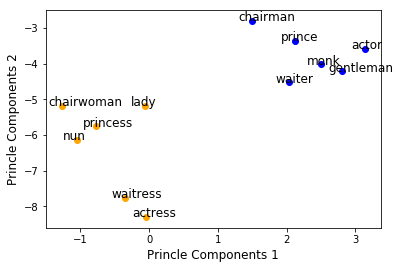

In [281]:
pc1 = 1
pc2 = 2
plt.scatter(proj_gendercoref_he[:,pc1 - 1], proj_gendercoref_he[:,pc2 - 1], color='blue')
plt.scatter(proj_gendercoref_she[:,pc1 - 1], proj_gendercoref_she[:,pc2 - 1], color='orange')
plt.xlabel('Princle Components %d'%(pc1), fontsize=12)
plt.ylabel('Princle Components %d'%(pc2), fontsize=12)
for ind in range(6):
    plt.annotate(gendercoref_male_words[ind], (proj_gendercoref_he[ind][pc1 - 1]-0.2, proj_gendercoref_he[ind][pc2 - 1]), fontsize=12)
for ind in range(6):
    plt.annotate(gendercoref_female_words[ind], (proj_gendercoref_she[ind][pc1 - 1]-0.2, proj_gendercoref_she[ind][pc2 - 1]), fontsize=12)

In [336]:
he_elmos = np.array(he_elmos_anti + he_elmos_pro)
she_elmos = np.array(she_elmos_pro + she_elmos_anti)

In [283]:
import random
random.seed(101)

In [285]:
def get_proj(he_elmos, she_elmos, pcs, n, rands):
    pc_she = []
    pc_he = []
    for ind in rands:
        tmp = []
        for i in range(n):
            he_emb = he_elmos[ind].reshape(-1, 3072)
            pj1 = he_emb.dot(pcs[i])
            tmp.append(pj1)
        pc_he.append(np.array(tmp))
        tmp = []
        for i in range(n):
            she_emb = she_elmos[ind].reshape(-1, 3072)
            pj1 = she_emb.dot(pcs[i])
            tmp.append(pj1)
        pc_she.append(np.array(tmp))
    return np.array(pc_she), np.array(pc_he)
    

In [256]:
male = '/home/jyzhao/Github/data/corefBias/WinoBias/wino/data/male_occupations.txt'
female = '/home/jyzhao/Github/data/corefBias/WinoBias/wino/data/female_occupations.txt'
male_occs = [x.strip() for x in open(male).readlines()]
female_occs = [x.strip() for x in open(female).readlines()]

In [158]:
alre = set()
occs = []
for ind in range(len(she_res)):
    if she_res[ind][0] in male_occs+female_occs:
        if she_res[ind][0] not in occs:
            occs.append(she_res[ind][0])
            alre.add(ind)

In [356]:
def plot_pcs(pc_he, pc_she, pc1, pc2, he_res):
    plt.close('all')
    plt.scatter(pc_he[:,pc1 - 1], pc_he[:,pc2 - 1], color='blue')
    plt.scatter(pc_she[:,pc1 - 1], pc_she[:,pc2 - 1], color='orange')
    plt.xlabel('Princle Components %d'%(pc1), fontsize=12)
    plt.ylabel('Princle Components %d'%(pc2), fontsize=12)
    for ind in range(len(rands)):
        print(he_res_pro[rands[ind]][0])
        if ind == 7:  
            plt.annotate(he_res[rands[ind]][0], 
                             (pc_he[ind][pc1 - 1]-0.2, pc_he[ind][pc2 - 1]), fontsize=12)
        elif ind == 6:
            plt.annotate(he_res[rands[ind]][0], 
                             (pc_he[ind][pc1 - 1] , pc_he[ind][pc2 - 1]), fontsize=12)
        elif ind == 9:
            plt.annotate(he_res[rands[ind]][0], 
                             (pc_he[ind][pc1 - 1]+0.3, pc_he[ind][pc2 - 1]-0.1), fontsize=12)
        else:
            plt.annotate(he_res[rands[ind]][0], 
                             (pc_he[ind][pc1 - 1] , pc_he[ind][pc2 - 1]  ), fontsize=12)
        if ind in [3]:
            plt.annotate(she_res[rands[ind]][0], 
                             (pc_she[ind][pc1 - 1] , pc_she[ind][pc2 - 1] ), fontsize=12)
        elif ind in [7]:
            plt.annotate(she_res[rands[ind]][0], 
                             (pc_she[ind][pc1 - 1]+0.19, pc_she[ind][pc2 - 1]-0.1), fontsize=12)
        elif ind in [2]:
            plt.annotate(she_res[rands[ind]][0], 
                             (pc_she[ind][pc1 - 1]-0.29, pc_she[ind][pc2 - 1]-0.2), fontsize=12)
        elif ind in [9]:
            plt.annotate(she_res[rands[ind]][0], 
                             (pc_she[ind][pc1 - 1]-0.51, pc_she[ind][pc2 - 1]+0.1), fontsize=12)
        else:
            plt.annotate(she_res[rands[ind]][0], 
                             (pc_she[ind][pc1 - 1] , pc_she[ind][pc2 - 1] ), fontsize=12)
#         plt.savefig('pc%d%d.pdf'%(pc1, pc2))
        print(str(ind) + ': ' + she_res[rands[ind]][2])

In [546]:
rands = list(alre)
rands = [10, 7, 8, 80, 140]

In [547]:
for ind in rands:
#     print(str(ind) +":" + he_res_anti[ind][0] + "||\t" + he_res_anti[ind][2])
    print(str(ind) +":" + she_res_pro[ind][0] + "||\t" + she_res_pro[ind][2])
    
    print(str(ind) +":" + she_res_anti[ind][0] + "||\t" + she_res_anti[ind][2])
#     print(str(ind) +":" + she_res_anti[ind][0] + "||\t" + she_res_anti[ind][2])
    

10:secretary||	The developer corrected the secretary because she made a mistake .
10:lawyer||	The lawyer looked into illegal accusations against the cashier , because she needed to understand the case .
7:nurse||	The nurse was running from the laborer because she was very busy .
7:chief||	The chief encouraged the writer because she likes the book .
8:cashier||	The lawyer looked into illegal accusations against the cashier , but she may have been falsely accused .
8:developer||	The developer was unable to communicate with the writer because she only understands the code .
80:cleaner||	The analyst asked the cleaner to pick up papers because she always forgot .
80:driver||	The driver transported the counselor to the hospital because she was paid .
140:librarian||	The chief returned a book to the librarian but she complained of being late .
140:physician||	The physician hired the secretary because she was overwhelmed with clients .


In [548]:
pc_she_anti, pc_he_pro = get_proj(he_elmos_pro, she_elmos_anti, pca.components_, 3, rands )
pc_she_pro, pc_he_anti = get_proj(he_elmos_anti, she_elmos_pro, pca.components_, 3, rands )

In [549]:
pc_she_anti.shape

(5, 3, 1)

In [550]:
pc_he = np.concatenate((pc_he_pro, pc_he_anti), axis = 0)
pc_she = np.concatenate((pc_she_anti, pc_she_pro), axis = 0)

In [508]:
# pc_he = pc_he_pro
# pc_she = pc_she_anti

In [509]:
pc_he.shape

(6, 3, 1)

In [460]:
gendercoref_tmp = h5py.File('./elmo_cache_gendercoref_tmp.hdf5')

In [440]:
list(gendercoref_tmp.keys())

['nw:0_0', 'nw:100_0', 'nw:1_0', 'nw:2_0', 'nw:3_0', 'nw:4_0']

In [396]:
gendercoref_tmp['nw:0_0']['0']

<HDF5 dataset "0": shape (5, 1024, 3), type "<f4">

In [405]:
gendercoref_female_elmos = []
gendercoref_male_elmos = []
she_keys = ['nw:0_0', 'nw:1_0', 'nw:3_0']
for key in gendercoref_tmp:
    if key in she_keys:
        gendercoref_female_elmos.append(gendercoref_tmp[key]['0'][3])
    else:
        gendercoref_male_elmos.append(gendercoref_tmp[key]['0'][3])
        
proj_gendercoref_he = []
proj_gendercoref_she = []
pcs = pca.components_
for ind in range(len(gendercoref_female_elmos)):
        tmp = []
        for i in range(3):
            he_emb = gendercoref_male_elmos[ind].reshape(-1, 3072)
            pj1 = he_emb.dot(pcs[i])
            tmp.append(pj1)
        proj_gendercoref_he.append(np.array(tmp))
        tmp = []
        for i in range(3):
            she_emb = gendercoref_female_elmos[ind].reshape(-1, 3072)
            pj1 = she_emb.dot(pcs[i])
            tmp.append(pj1)
        proj_gendercoref_she.append(np.array(tmp))
proj_gendercoref_she = np.array(proj_gendercoref_she)
proj_gendercoref_he = np.array(proj_gendercoref_he)

In [441]:
print(len(gendercoref_female_elmos))
proj_gendercoref_he.shape

3


(3, 3, 1)

In [551]:
pc_she2plot = np.concatenate((pc_she, proj_gendercoref_she), axis=0)
pc_he2plot = np.concatenate((pc_he, proj_gendercoref_he), axis=0)

In [552]:
pc_she2plot.shape

(13, 3, 1)

In [555]:
words0 = [ 'laywer', 'chief', 'developer',  'driver',  'physician',    \
          'secretary', 'nurse', 'cashier', 'cleaner',  'librarian' ]#, 'salesperson', 'secretary', 'laborer', 'hairdress']
gendercoref_female_words = ['actress', 'waitress', 'princess']
gendercoref_male_words = ['actor', 'waiter', 'prince']
# words2plot = words0+words

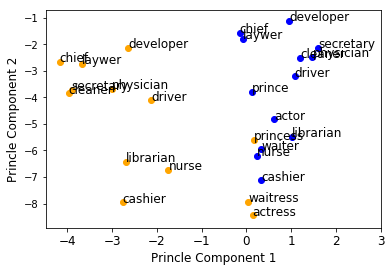

In [566]:
pc1 =1 
pc2 = 2
pc3 = 3
plt.close('all')
ax = plt.subplot(111)
ax.scatter(pc_he2plot[:,pc1 - 1], pc_he2plot[:,pc2 - 1], color='blue')
ax.scatter(pc_she2plot[:,pc1 - 1], pc_she2plot[:,pc2 - 1], color='orange')
plt.xticks(np.arange(-4, 4, 1), fontsize=12)
plt.xlabel('Princle Component %d'%(pc1), fontsize=12)
plt.ylabel('Princle Component %d'%(pc2), fontsize=12)
for ind in range(len(words0)):
    plt.annotate(words0[ind], 
                             (pc_he2plot[ind][pc1 - 1], pc_he2plot[ind][pc2 - 1] ), fontsize=12)
    plt.annotate(words0[ind], 
                             (pc_she2plot[ind][pc1 - 1] , pc_she2plot[ind][pc2 - 1] ), fontsize=12)
for ind in range(len(gendercoref_female_words)):
    plt.annotate(gendercoref_female_words[ind], 
                (pc_she2plot[ind+len(words0)][pc1 - 1] , pc_she2plot[ind+len(words0)][pc2 - 1]), fontsize=12)
for ind in range(len(gendercoref_male_words)):
    plt.annotate(gendercoref_male_words[ind], 
                (pc_he2plot[ind+len(words0)][pc1 - 1] , pc_he2plot[ind+len(words0)][pc2 - 1]), fontsize=12)
# ax.spines['right'].set_visible(False)
# ax.spines['top'].set_visible(False)
plt.savefig('pca1.pdf')

mechanic
0: The mechanic greets the receptionist because she was standing in front of the door .
assistant
1: The cook is always teaching the assistant new techniques so she will one day be equal in skill .
teacher
2: The farmer gave the teacher a bag of eggs because she helped many kids .
chief
3: The chief encouraged the writer because she wrote a good book .
nurse
4: The nurse was running from the laborer because she was very busy .
lawyer
5: The lawyer looked into illegal accusations against the cashier , but she may have been falsely accused .
salesperson
6: The salesperson sold some books to the librarian because she wanted to learn .
secretary
7: The developer corrected the secretary because she made a mistake .
laborer
8: The laborer eats more than the receptionist as she is on a diet .
hairdresser
9: The laborer raced against the hairdresser because she is slow .


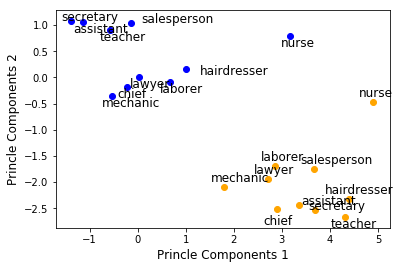

In [300]:
#PC1 vs PC2/
plot_pcs(pc_he, pc_she, 1, 2)

0: The developer corrected the secretary because she made a mistake .
1: The secretary went to a meeting with the construction worker because she was asked to .
2: The farmer gave the teacher a bag of eggs because she helped many kids .
3: The construction worker stared at the teacher because she entered the construction zone .
4: The analyst argued with the designer , because she refused to redesign the work .
5: The mechanic greets the receptionist because she was standing in front of the door .
6: The lawyer yelled at the hairdresser because she did a bad job .
7: The driver yelled at the tailor after she broke a window .
8: The chief encouraged the writer because she wrote a good book .
9: The mover missed the call from the assistant because she tried to schedule the moving .


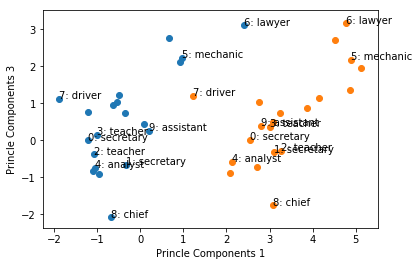

In [72]:
plot_pcs(pc_he, pc_she, 1, 3)

0: The nurse examined the farmer for injuries because she was caring .
1: The cook prepared a soup for the housekeeper because she helped to clean the room .
2: The sheriff trusts the assistant because she was always honest .
3: The secretary asked the mover what she could do to help .
4: The construction worker stared at the teacher because she entered the construction zone .
5: The cleaner hates the developer because she spent a lot of time cleaning the room .
6: The manager told the clerk to report to work early because she is lazy .
7: The CEO helped the nurse because she needed help .
8: The driver never drove the librarian anywhere because she wore silly hats .


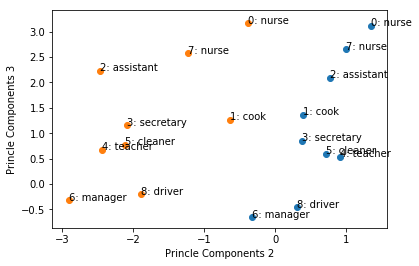

In [558]:
plot_pcs(pc_he, pc_she, 2, 3)

In [559]:
from sklearn.manifold import TSNE

In [560]:
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)

In [561]:
tmp = he_elmos[:3]
tmp.shape

(3, 1024, 3)

In [562]:
tmp.sum(axis = 2).shape

(3, 1024)

In [563]:
he_fla = he_elmos.reshape(-1, 3072)
she_fla = she_elmos.reshape(-1, 3072)
she_x = [she_fla[x] for x in rands]
he_x = [he_fla[x] for x in rands]
x2d = tsne.fit_transform(he_x)
f = tsne.fit_transform(she_x)
tmp = tsne.fit_transform(he_x + she_x)

[t-SNE] Computing 8 nearest neighbors...
[t-SNE] Indexed 9 samples in 0.000s...
[t-SNE] Computed neighbors for 9 samples in 0.023s...
[t-SNE] Computed conditional probabilities for sample 9 / 9
[t-SNE] Mean sigma: 1125899906842624.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 36.722172
[t-SNE] Error after 300 iterations: 0.400972
[t-SNE] Computing 8 nearest neighbors...
[t-SNE] Indexed 9 samples in 0.000s...
[t-SNE] Computed neighbors for 9 samples in 0.000s...
[t-SNE] Computed conditional probabilities for sample 9 / 9
[t-SNE] Mean sigma: 1125899906842624.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 53.902241
[t-SNE] Error after 300 iterations: 0.304615
[t-SNE] Computing 17 nearest neighbors...
[t-SNE] Indexed 18 samples in 0.000s...
[t-SNE] Computed neighbors for 18 samples in 0.001s...
[t-SNE] Computed conditional probabilities for sample 18 / 18
[t-SNE] Mean sigma: 1125899906842624.000000
[t-SNE] KL divergence after 250 ite

In [564]:
x2d.shape

(9, 2)

0: The nurse examined the farmer for injuries because she was caring .
1: The cook prepared a soup for the housekeeper because she helped to clean the room .
2: The sheriff trusts the assistant because she was always honest .
3: The secretary asked the mover what she could do to help .
4: The construction worker stared at the teacher because she entered the construction zone .
5: The cleaner hates the developer because she spent a lot of time cleaning the room .
6: The manager told the clerk to report to work early because she is lazy .
7: The CEO helped the nurse because she needed help .
8: The driver never drove the librarian anywhere because she wore silly hats .


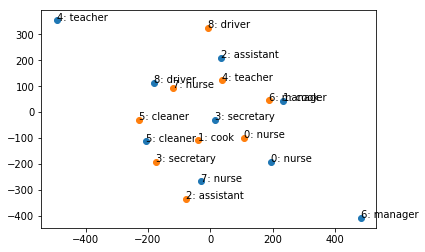

In [565]:
plt.close('all')
# f = x2d[len(he_x):]
plt.scatter(x2d[:len(he_x)][:,0], x2d[:len(he_x)][:,1])
plt.scatter(f[:][:,0], f[:][:,1])
for ind in range(len(rands)):
        plt.annotate(str(ind) + ': ' + he_res[rands[ind]][0], 
                     (x2d[ind][0], x2d[ind][1]))
        plt.annotate(str(ind) + ': ' + she_res[rands[ind]][0], 
                     (f[ind][0], f[ind][1]))
        print(str(ind) + ': ' + she_res[rands[ind]][1])

0: The nurse examined the farmer for injuries because she was caring .
1: The cook prepared a soup for the housekeeper because she helped to clean the room .
2: The sheriff trusts the assistant because she was always honest .
3: The secretary asked the mover what she could do to help .
4: The construction worker stared at the teacher because she entered the construction zone .
5: The cleaner hates the developer because she spent a lot of time cleaning the room .
6: The manager told the clerk to report to work early because she is lazy .
7: The CEO helped the nurse because she needed help .
8: The driver never drove the librarian anywhere because she wore silly hats .


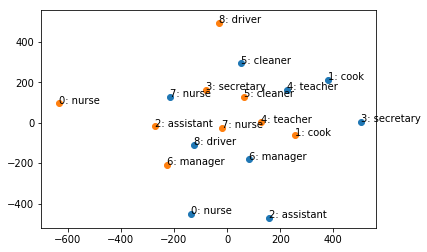

In [566]:
plt.close('all')
f = tmp[len(he_x):]
plt.scatter(tmp[:len(he_x)][:,0], tmp[:len(he_x)][:,1])
plt.scatter(tmp[len(he_x):][:,0], tmp[len(he_x):][:,1])
for ind in range(len(rands)):
        plt.annotate(str(ind) + ': ' + he_res[rands[ind]][0], 
                     (tmp[ind][0], tmp[ind][1]))
        plt.annotate(str(ind) + ': ' + she_res[rands[ind]][0], 
                     (f[ind][0], f[ind][1]))
        print(str(ind) + ': ' + she_res[rands[ind]][1])

### Projecting out for all  non-gender definitional words

In [57]:
dev = 'data/anonymized/dev.english.jsonlines'
dev_all_genders = utils.get_all_genders(dev)
train = 'data/anonymized/train.english.jsonlines'
train_all_genders = utils.get_all_genders(train)
test = 'data/anonymized/test.english.jsonlines'
test_all_genders = utils.get_all_genders(test)

In [58]:
train_file = 'elmo_cache_train.hdf5'
train_cache = h5py.File(train_file, 'r')
dev_file = 'elmo_cache_dev.hdf5'
dev_cache = h5py.File(dev_file, 'r')
test_file = 'elmo_cache_test.hdf5'
test_cache = h5py.File(test_file, 'r')

In [ ]:
# train_elmo = np.array(utils.get_gender_elmo(train_cache, train_all_genders))
dev_elmo = np.array(utils.get_gender_elmo(dev_cache, dev_all_genders))
test_elmo = np.array(utils.get_gender_elmo(test_cache, test_all_genders))
train_elmo = np.load('train_ori_ELMos.npy')

In [61]:
np.save('dev_ori_ELMos', dev_elmo)
np.save('test_ori_ELMos', test_elmo)

In [60]:
len(train_elmo)

334206

In [521]:
##same as the get_gender_elmo
def get_ori_ELMo(train_all_genders, train_ori):
    count = 0
    ori = []
    for key in tqdm(train_all_genders):
        if len(train_all_genders[key]) == 0:  #no gender definition word in the document
            continue
        elmo_key = key.replace('/', ':')
        for gid in train_ori[elmo_key]:
            if int(gid) not in train_all_genders[key]:  #no gender definiton word in the sentence
                continue

            for wid in range(train_ori[elmo_key][str(gid)].shape[0]):
                if wid in train_all_genders[key][int(gid)]:  #this is a gender definition word
                    continue
                else:
                    ori.append(train_ori[elmo_key][str(gid)][wid])
                    count = len(ori)
    return np.array(ori)

In [62]:
def project_out(elmos, pcs, n):
    res = []
    for ind in range(len(elmos)):
        tmp = elmos[ind].reshape(-1, 3072)
        for i in range(n):
            tmp -= np.multiply((tmp.dot(pcs[i]) / (pcs[i].dot(pcs[i]))).reshape(-1,1), 
                                       pcs[i].reshape(1, -1))
        res.append(tmp)
    return np.array(res)

In [63]:
train_after_pca = project_out(train_elmo, pca.components_, 2)

In [64]:
dev_after_pca = project_out(dev_elmo, pca.components_, 2)
test_after_pca = project_out(test_elmo, pca.components_, 2)

In [80]:
def save_ELMo(train_all_genders, train_ori, fn, neutralized):
    with h5py.File("elmo_cache_pca_%s_part.hdf5"%(fn), "w") as out_file: 
        count = 0
        for key in train_all_genders.keys():
            elmo_key = key.replace('/', ':')
            group = out_file.create_group(elmo_key)
            if len(train_all_genders[key]) == 0:  #no gender definition word in the document
                for gid in train_ori[elmo_key]:
                    group[gid] = train_ori[elmo_key][gid][...]
                continue
            for gid in train_ori[elmo_key]:
                group[gid] = train_ori[elmo_key][gid][...]
                if int(gid) not in train_all_genders[key]:  #no gender definiton word in the sentence; no need to update
                    continue

                for wid in range(train_ori[elmo_key][str(gid)].shape[0]):
                    if wid in train_all_genders[key][int(gid)]:  #this is a gender definition word; do not need to update
                        continue
                    else:
                        group[gid][wid] = neutralized[count].reshape(1,-1,3)
                        count += 1


In [585]:
save_ELMo(train_all_genders, train_cache, 'train', train_after_pca)

In [586]:
save_ELMo(dev_all_genders, dev_cache, 'dev', dev_after_pca)
save_ELMo(test_all_genders, test_cache, 'test', test_after_pca)

In [13]:
#for the swapped data:
train_file = 'elmo_caches/elmo_cache_train_swap.hdf5'
train_cache = h5py.File(train_file, 'r')
dev_file = 'elmo_caches/elmo_cache_dev_swap.hdf5'
dev_cache = h5py.File(dev_file, 'r')
test_file = 'elmo_caches/elmo_cache_test_swap.hdf5'
test_cache = h5py.File(test_file, 'r')

In [14]:
list(train_cache.keys())[0]

'bc:cctv:00:cctv_0001_0'

In [ ]:
train_elmo = np.array(utils.get_gender_elmo(train_cache, train_all_genders))
dev_elmo = np.array(utils.get_gender_elmo(dev_cache, dev_all_genders))
test_elmo = np.array(utils.get_gender_elmo(test_cache, test_all_genders))

In [590]:
train_after_pca = project_out(train_elmo, pca.components_, 2)
dev_after_pca = project_out(dev_elmo, pca.components_, 2)
test_after_pca = project_out(test_elmo, pca.components_, 2)

In [591]:
save_ELMo(train_all_genders, train_cache, 'train_swap', train_after_pca)

In [592]:
save_ELMo(dev_all_genders, dev_cache, 'dev_swap', dev_after_pca)
save_ELMo(test_all_genders, test_cache, 'test_swap', test_after_pca)

In [15]:
#combine
def combine_ori_swap(ori, swap, fn):
    with h5py.File("elmo_cache_pca_%s_part_union.hdf5"%fn, 'w') as out:
        for key in tqdm(ori):
            group = out.create_group(key)
            for gid in ori[key]:
                group[gid] = ori[key][gid][...]
        for key in tqdm(swap):
            akey = '_'.join(key.split('_')[:-1])+'_s_'+key.split('_')[-1]
            group = out.create_group(akey)
            for gid in swap[key]:
                group[gid] = swap[key][gid][...]

In [6]:
train_pca_ori = h5py.File('elmo_caches/elmo_cache_pca_train_part.hdf5', 'r')
train_pca_swap = h5py.File('elmo_caches/elmo_cache_pca_train_swap_part.hdf5', 'r')
dev_pca_ori = h5py.File('elmo_caches/elmo_cache_pca_dev_part.hdf5', 'r')
dev_pca_swap = h5py.File('elmo_caches/elmo_cache_pca_dev_swap_part.hdf5', 'r')

In [10]:
list(train_pca_ori.keys())[0]

'bc:cctv:00:cctv_0001_0'

In [11]:
list(train_pca_swap.keys())[0]

'bc:cctv:00:cctv_0001_0'

In [8]:
combine_ori_swap(train_pca_ori, dev_pca_ori, 'ori')
combine_ori_swap(train_pca_swap, dev_pca_swap, 'swap')

100%|██████████| 343/343 [05:35<00:00,  1.02it/s]


In [16]:
ori_pca = h5py.File('elmo_cache_pca_ori_part_union.hdf5', 'r')
swap_pca = h5py.File('elmo_cache_pca_swap_part_union.hdf5', 'r')
combine_ori_swap(ori_pca, swap_pca, 'all')

100%|██████████| 3145/3145 [55:00<00:00,  1.05s/it]


### Average

In [65]:
def get_avg_elmo5(fn, pro, anti, all_genders):
    with h5py.File("elmo_cache_pca_%s_avg.hdf5"%(fn), "w") as out_file:
        for key in tqdm(pro.keys()):
            group = out_file.create_group(key)
            fkey = key.replace(':', '/')
            akey = key
            if len(all_genders[fkey]) > 0:
                for gid in pro[key]:
                    tmp = []
#                     print(key, akey, fkey)
                    if int(gid) in all_genders[fkey].keys(): #This sentence including a gender defintion word
                        for wid in range(pro[key][gid].shape[0]):
                            if wid in all_genders[fkey][int(gid)]: #this word is a gender word; keep the original ELMo
                                tmp.append(pro[key][gid][wid])
                            else: #otherwise, average the ELMo
                                tmp.append((pro[key][gid][wid] + anti[akey][gid][wid]) / 2)
                        group[gid] = np.array(tmp)
                    else: #This sentence does not include a gender word
                        group[gid] = (pro[key][gid][...] + anti[akey][gid][...]) / 2
            else:
                for gid in pro[key]:
                    group[gid] = (pro[key][gid][...] + anti[akey][gid][...]) / 2

In [66]:
dev_file = 'elmo_cache_pca_dev_part.hdf5'
dev = h5py.File(dev_file, 'r')
dev_swap_file = 'elmo_cache_pca_dev_swap_part.hdf5'
dev_swap = h5py.File(dev_swap_file, 'r')

In [67]:
train_file = 'elmo_cache_pca_train_part.hdf5'
train = h5py.File(train_file, 'r')
train_swap_file = 'elmo_cache_pca_train_swap_part.hdf5'
train_swap = h5py.File(train_swap_file, 'r')
test_file = 'elmo_cache_pca_test_part.hdf5'
test = h5py.File(test_file, 'r')
test_swap_file = 'elmo_cache_pca_test_swap_part.hdf5'
test_swap = h5py.File(test_swap_file, 'r')

In [ ]:
get_avg_elmo5('test_part', test, test_swap, test_all_genders)
get_avg_elmo5('train_part', train, train_swap, train_all_genders)
get_avg_elmo5('dev_part', dev, dev_swap, dev_all_genders)

In [69]:
#combine
def combine(train, dev, fn):
    with h5py.File("elmo_cache_%s.hdf5"%(fn), 'w') as out:
        for key in tqdm(train):
            group = out.create_group(key)
            for gid in train[key]:
                group[gid] = train[key][gid][...]
        for key in tqdm(dev):
            group = out.create_group(key)
            for gid in dev[key]:
                group[gid] = dev[key][gid][...]

In [ ]:
combine(train, dev, "pca_part")

In [70]:
train_avg = h5py.File('elmo_cache_pca_train_part_avg.hdf5')
dev_avg = h5py.File('elmo_cache_pca_dev_part_avg.hdf5')

In [ ]:
combine(train_avg, dev_avg, "pca_part_avg")

### For winobias

In [74]:
dev_T1_genders = utils.get_all_genders('data/corefbias/dev_type1_pro_stereotype.english.jsonlines')
dev_T2_genders = utils.get_all_genders('data/corefbias/dev_type2_anti_stereotype.english.jsonlines')
test_T1_genders = utils.get_all_genders('data/corefbias/test_type1_anti_stereotype.english.jsonlines')
test_T2_genders = utils.get_all_genders('data/corefbias/test_type2_anti_stereotype.english.jsonlines')

In [75]:
file = 'elmo_cache_dev_T1_anti.hdf5'
dev_T1_anti = h5py.File(file, 'r')
file = 'elmo_cache_dev_T1_pro.hdf5'
dev_T1_pro = h5py.File(file, 'r')

file = 'elmo_cache_dev_T2_anti.hdf5'
dev_T2_anti = h5py.File(file, 'r')
file = 'elmo_cache_dev_T2_pro.hdf5'
dev_T2_pro = h5py.File(file, 'r')

file = 'elmo_cache_test_T1_anti.hdf5'
test_T1_anti = h5py.File(file, 'r')
file = 'elmo_cache_test_T1_pro.hdf5'
test_T1_pro = h5py.File(file, 'r')

file = 'elmo_cache_test_T2_anti.hdf5'
test_T2_anti = h5py.File(file, 'r')
file = 'elmo_cache_test_T2_pro.hdf5'
test_T2_pro = h5py.File(file, 'r')

In [ ]:
dev_T1_pro_after_pca = project_out(np.array(utils.get_gender_elmo(dev_T1_pro, dev_T1_genders)), pca.components_, 2)
dev_T1_anti_after_pca = project_out(np.array(utils.get_gender_elmo(dev_T1_anti, dev_T1_genders)), pca.components_, 2)
test_T1_pro_after_pca = project_out(np.array(utils.get_gender_elmo(test_T1_pro, test_T1_genders)), pca.components_, 2)
test_T1_anti_after_pca = project_out(np.array(utils.get_gender_elmo(test_T1_anti, test_T1_genders)), pca.components_, 2)

dev_T2_pro_after_pca = project_out(np.array(utils.get_gender_elmo(dev_T2_pro, dev_T2_genders)), pca.components_, 2)
dev_T2_anti_after_pca = project_out(np.array(utils.get_gender_elmo(dev_T2_anti, dev_T2_genders)), pca.components_, 2)
test_T2_pro_after_pca = project_out(np.array(utils.get_gender_elmo(test_T2_pro, test_T2_genders)), pca.components_, 2)
test_T2_anti_after_pca = project_out(np.array(utils.get_gender_elmo(test_T2_anti, test_T2_genders)), pca.components_, 2)

In [81]:
save_ELMo(dev_T1_genders, dev_T1_pro, 'dev_T1_pro', dev_T1_pro_after_pca)
save_ELMo(dev_T1_genders, dev_T1_anti, 'dev_T1_anti', dev_T1_anti_after_pca)
save_ELMo(dev_T2_genders, dev_T2_pro, 'dev_T2_pro', dev_T2_pro_after_pca)
save_ELMo(dev_T2_genders, dev_T2_anti, 'dev_T2_anti', dev_T2_anti_after_pca)
save_ELMo(test_T1_genders, test_T1_pro, 'test_T1_pro', test_T1_pro_after_pca)
save_ELMo(test_T1_genders, test_T1_anti, 'test_T1_anti', test_T1_anti_after_pca)
save_ELMo(test_T2_genders, test_T2_pro, 'test_T2_pro', test_T2_pro_after_pca)
save_ELMo(test_T2_genders, test_T2_anti, 'test_T2_anti', test_T2_anti_after_pca)

In [ ]:
dev_T1_pro_file = 'elmo_cache_pca_dev_T1_pro_part.hdf5'
dev = h5py.File(dev_T1_pro_file, 'r')
dev_swap_file = 'elmo_cache_pca_dev_T1_anti_part.hdf5'
dev_swap = h5py.File(dev_swap_file, 'r')
get_avg_elmo5('dev_T1_pro_part', dev, dev_swap, dev_T1_genders)
get_avg_elmo5('dev_T1_anti_part', dev_swap, dev, dev_T1_genders)

dev_T2_pro_file = 'elmo_cache_pca_dev_T2_pro_part.hdf5'
dev = h5py.File(dev_T2_pro_file, 'r')
dev_swap_file = 'elmo_cache_pca_dev_T2_anti_part.hdf5'
dev_swap = h5py.File(dev_swap_file, 'r')
get_avg_elmo5('dev_T2_pro_part', dev, dev_swap, dev_T2_genders)
get_avg_elmo5('dev_T2_anti_part', dev_swap, dev, dev_T2_genders)

In [ ]:
test_T1_pro_file = 'elmo_cache_pca_test_T1_pro_part.hdf5'
test = h5py.File(test_T1_pro_file, 'r')
test_swap_file = 'elmo_cache_pca_test_T1_anti_part.hdf5'
test_swap = h5py.File(test_swap_file, 'r')
get_avg_elmo5('test_T1_pro_part', test, test_swap, test_T1_genders)
get_avg_elmo5('test_T1_anti_part', test_swap, test, test_T1_genders)

test_T2_pro_file = 'elmo_cache_pca_test_T2_pro_part.hdf5'
test = h5py.File(test_T2_pro_file, 'r')
test_swap_file = 'elmo_cache_pca_test_T2_anti_part.hdf5'
test_swap = h5py.File(test_swap_file, 'r')
get_avg_elmo5('test_T2_pro_part', test, test_swap, test_T2_genders)
get_avg_elmo5('test_T2_anti_part', test_swap, test, test_T2_genders)